# NLP, N-grams and FastText

As you have seen in the lectures, NLP has a wide range of techniques and applications of such techniques. We will give you an introduction to some of these techniques, and today you will get hands-on experience with them. In today's exercise, we will look at the following topics:

1. How do we represent text in a vectorized way that encodes context? (One answer here is N-grams, and those we will look at).
2. How do we create and sample from an N-gram language model - and how does the size of the grams affect the generated text?
3. How do we use a pre-existing language model (FastText), to classify text messages as spam?

The data we will be using later today is a dataset consisting of "spam or ham" text messages. The dataset consists of a number of text messages, some of which are spam and some of which are so-called "ham". We will use FastText to classify mails as spam or ham. For now, we will be looking at some different texts, to see how we can use N-grams to generate text, and how we can create N-gram language models from a text corpus.

## Exercise 1: Text-loading


The texts we will be experimenting with N-grams on are the two famous books Pride & Prejudice by Jane Austen and The Origin of Species by Charles Darwin. The two books have been obtained in a raw text format from https://www.gutenberg.org/, i.e. Project Gutenberg which concerns itself with the collection of Open Access e-books.

A big part of working with text documents is unfortunately having to preprocess the documents. Preprocessing of these, can have a large impact on the eventual performance of language models, such as N-gram models. We have included the text-preprocessing steps in the cell below. In the output cell you will notice that the first chapter of pride and prejudice is printed out. It is then preprocessed using the `preprocess_text` function and printed out again.

**1. Implement the pre_processing function according to the following description:**
1. All text should be lowercase *Python strings have an in-built method for that*
2. Remove all special characters by using the regex pattern `r"[^a-zA-Z0-9.?! \n]+"` and the sub function from Python's re module
3. Split the text by lines *"\n" is the character used for newlines*
4. Remove chapter headlines
5. Recreate the full document again using `"\n".join(text)`
6. Replace `"\n"` with `" "` and double-spacing with single spacing

In [199]:
import re
import os
import torch
import fasttext

import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def preprocess_text(text):
    text = text.lower() #Lowercase everything in text file.
    text = re.sub(r"[^a-zA-Z0-9.?! \n]+", "", text) #Remove unwanted special characters.
    text = text.split("\n") #Split text by lines.
    text = [line.strip() for line in text if line.find("chapter") == -1] #Remove chapter headlines.
    text = "\n".join(text) #Recreate full document again
    text = text.replace("\n", " ").replace("  ", " ") #Remove end lines and remove double spacing.
    return text

**2. The preprocessing is not perfect. Do you notice any issues in the text? Show examples of words that will may be problematic:**

*HINT: What happens to *good-humoured*? What happens to *three-and-twenty*? What happens to *Mr.* and *Mrs.*, and how will this later be handled when we split the sentences?*

In [40]:
print(preprocess_text("good-humoured"))
print(preprocess_text("Mr."))
print(preprocess_text("I am, but"))

goodhumoured
mr.
i am but


**3. Apply the preprocessing to Pride and Prejudice and the Origin of Species**

In [4]:
with open("data/pride_and_prejudice.txt", "r", encoding="utf-8") as file:
    pride_n_pred = file.read()
    pride_n_pred_preproc = preprocess_text(pride_n_pred)

In [5]:
with open("data/pride_and_prejudice.txt", "r", encoding="utf-8") as file:
    orig_of_spec = file.read()
    orig_of_spec_preproc = preprocess_text(orig_of_spec)

## Exercise 2: Creating N-grams

Now that we have the texts in the preprocessed document format we want, we will move forward with the creation of our N-grams. Recall we want to use the N-grams for probabilistic word modelling tasks, for example, next word predictions given some sequence of words which we can express the following way:

\begin{equation}
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1})
\end{equation}

The problem is that estimating such probabilities for very long sequences is computationally and memory-wise VERY expensive. So as a solution we sometimes use N-grams. In N-grams, the assumption is that we can model these conditional dependencies with shorter sequences of words, i.e.:

\begin{equation}
\begin{split}
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n) & \text{(Unigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n| w_{n-1}) & \text{(Bigram)}\\
P(w_n|w_1, w_2, ..., w_{n-2}, w_{n-1}) & \approx P(w_n|w_{n-2}, w_{n-1}) & \text{(Trigram)}\\
\end{split}
\end{equation}

Which we then compute as:

\begin{equation}
P(w_n|w_{n-2}, w_{n-1}) = \frac{\text{Count}(w_{n-2}, w_{n-1}, w_n)}{\text{Count}(w_{n-2}, w_{n-1})}
\end{equation}

The language model that we create is based on some text corpus from which we obtain the count measures. In this exercise we will try making such N-gram models on the two books Origin of Species and Pride and Prejudice!

In the cell below we have written the functions required for preprocessing a corpus even further such that it is ready for creating an N-gram model on. In order to guarantee that we can just start text generation or give conditional probabilites for how likely a start or end word is in given sentence we pad our sentence with start and end tokens denoted as `<s>` and `</s>` according to the size of N-grams we are working with.

**1. Why do N-grams encode context in comparison to methods such as count vectorizers which just count words?**

**2. Implement the function `tokenize_and_pad` that takes a corpus and a parameter `N` specifying the amount of padding to apply and returns a list of lists where the inner lists are sentences split into words**
1. Split the corpus into sentences *Using a full stop at the delimiter*
2. Calculate the length of the padding needed
    - Think about how many words are needed to create the first N-gram? *Hint: The first actual word is included*
3. Create the padding for the front and end using for example `" ".join(list_of_start_chars)`
    - In Python you can create a list of length pad_len using `[el] * pad_len`
4. Pad each corpus sentence ensuring that there is a space between the padding and sentence
    - Use the .strip() method on each sentence to remove empty characters
Split the padded sentences into words and return a list of lists containing the split sentences

In [6]:
def tokenize_and_pad(corpus, N=3):
    corpus_sentences = corpus.split(".")
    pad_len = N - 1
    pad_front = " ".join(["<s>"]*pad_len)
    pad_end = " ".join(["</s>"]*pad_len)
    padded_corpus_sentences = [pad_front + " " + sentence.strip() + " " + pad_end for sentence in corpus_sentences]
    tokenized_corpus_sentences = [sentence.split(" ") for sentence in padded_corpus_sentences]
    return tokenized_corpus_sentences


In [12]:
N = 3
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
print(orig_of_spec_tokenize[0])

['<s>', '<s>', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '</s>', '</s>']


**3. Implement the function `create_n_grams` which takes the output from the above function and splits it into n_grams**
1. Create and empty list for the n_grams
2. Loop across all the tokenized sentences
3. Now loop across the range of applicable starting indexes for the given sentence
    - If N = 2, what's the length of the sentences list and how many N_grams can we create? Generalise this.
4. Create the current n_gram by using `" ".join`
5. Return the n_grams list


In [7]:
def create_n_grams(tokenized_sentences, N=3):
    n_grams = []
    for sentence in tokenized_sentences:
        for i in range(len(sentence) - N + 1):
            # Create each n-gram by joining N consecutive words
            n_gram = " ".join(sentence[i:i + N])
            n_grams.append(n_gram)
    return n_grams

In [13]:
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
print(orig_of_spec_n_grams[:20])

['<s> <s> it', '<s> it is', 'it is a', 'is a truth', 'a truth universally', 'truth universally acknowledged', 'universally acknowledged that', 'acknowledged that a', 'that a single', 'a single man', 'single man in', 'man in possession', 'in possession of', 'possession of a', 'of a good', 'a good fortune', 'good fortune must', 'fortune must be', 'must be in', 'be in want']


**4. Implement the function `n_grams_to_prob_map` which takes a list of n_grams as returned by the function above and create a dictionary which maps the probabilities of words occurring after a given context.**
1. If you are unfamiliar with the defaultdict class in Python, read this article before you start this task https://www.geeksforgeeks.org/defaultdict-in-python/
2. If you are unfamiliar with the lambda keyword in Python, read this article before you start this task https://www.geeksforgeeks.org/python-lambda-anonymous-functions-filter-map-reduce/?ref=header_outind
3. Create a default dict, name it `contexts`, with a default value that is a default dict whose default value is 0
    - In essence: defaultdict(defaultdict(0))
    - This will be used to count how often each target word occurs after a certain context
4. Loop through every n-gram and split it
5. Create the context by using `" ".join` on all but the last token in the n-gram. The last token is the target
6. Increment (means adding 1 to a value) the counter for the target value for the given context
7. Create a new dictionary `cond_prob`
8. Loop across the keys of `contexts`
9. Create a list of each target in the current context by wrapping the .keys() call in a list()
10. Count the number of occurrences of each target in the current context and put them in a numpy array
11. Calculate the probabilities of each target by normalising the occurrence count 
    - Ensure it sums to 1
12.  Assign a tuple of the targets and their probabilities to the entry in the `cond_prob` function
    - The order of the tuple is important for later, so (context_targets, targets_probs)


In [8]:
def nested_default_dict():
    return defaultdict(lambda: 0)

def n_grams_to_prob_map(n_grams):
    contexts = defaultdict(nested_default_dict)
    for n_gram in n_grams:
        n_gram_split = n_gram.split(" ")
        context = " ".join(n_gram_split[:N-1])
        target = n_gram_split[N-1]
        contexts[context][target] += 1

    cond_prob = {}
    for context in contexts.keys():
        context_targets = list(contexts[context].keys())
        targets_count = np.array([contexts[context][target] for target in context_targets])
        context_sum = np.sum(targets_count)
        targets_probs = targets_count / context_sum
        cond_prob[context] = (context_targets, targets_probs,)
    return cond_prob

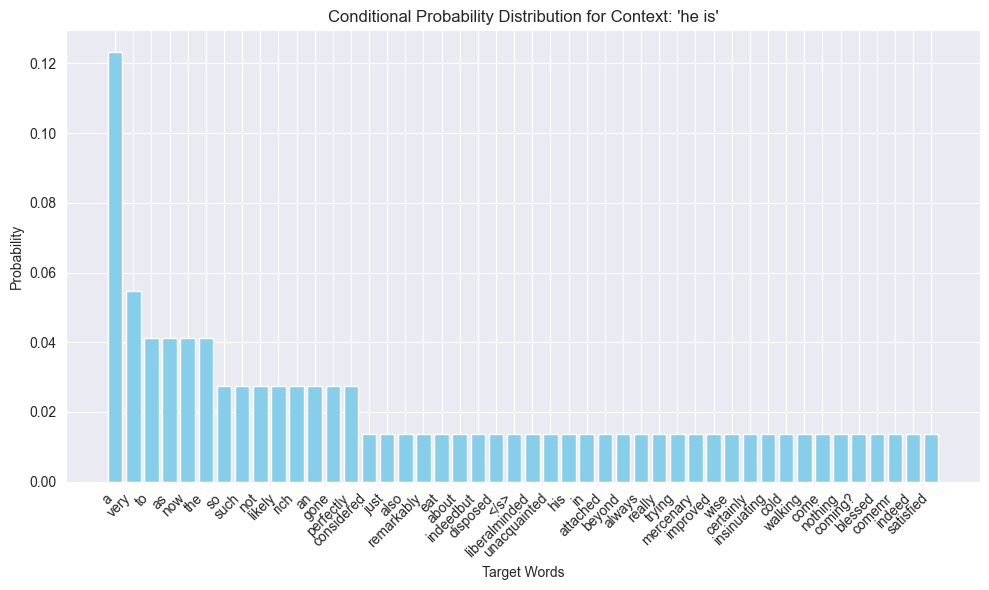

In [33]:
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
context_test = " ".join(orig_of_spec_n_grams[60].split(" ")[:-1])   # "he is" has a good number of targets
targets, probs = orig_of_spec_cond_prob[context_test]

sorted_targets, sorted_probs = zip(*sorted(zip(targets, probs), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_targets, sorted_probs, color='skyblue')
plt.xlabel("Target Words")
plt.ylabel("Probability")
plt.title(f"Conditional Probability Distribution for Context: '{context_test}'")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout for readability
plt.show()

**5. Vary the N-gram size N and inspect the first 20 N-grams.**
 - How do they change and why? 
 - Do you think there could be issues with this?

In [9]:
N=3
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
print(orig_of_spec_tokenize[0])
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
print(orig_of_spec_n_grams[:20])

['<s>', '<s>', 'it', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '</s>', '</s>']
['<s> <s> it', '<s> it is', 'it is a', 'is a truth', 'a truth universally', 'truth universally acknowledged', 'universally acknowledged that', 'acknowledged that a', 'that a single', 'a single man', 'single man in', 'man in possession', 'in possession of', 'possession of a', 'of a good', 'a good fortune', 'good fortune must', 'fortune must be', 'must be in', 'be in want']


## Exercise 3: Generating Text

In the previous exercise we saw how to tokenize a corpus such that it is ready to be split into n-grams. We then saw how to make n-grams and create a conditional probability based on these.

The question now is, how can we generate a text using this conditional probability. A way of doing this is to sample from a conditional probability distribution based on our obtained N-grams. In essence, we can give a seed to our conditional probability (also called a context), and then we need to generate a word from our conditional probability by sampling from it.

In the code below we will define a function that allows us to generate a sentence based on a provided conditional distribution. In the cell we create such a conditional distribution and generate 5 sentences using the same text seed. 

**1. Implement the `generate_text` function.**
1. Create a variable which will be the output string and assign the text_seed to it
2. Split the text_seed into words and check its length, it should be N-1
    - If the text seed is too short append the start character to it
    - If the text seed is too long change it to the last N-1 words
3. Create a variable that holds the current context (text_seed right now)
4. Loop across the number of words we wish to generate
   - If the current context is not in the `cond_prob` dictionary, return the generated sentence
   - If it is, sample a target word from the context according to its probability distribution and update the context for the next iteration


In [35]:
def generate_text(cond_prob, text_seed, N, num_words=25):
    generated_sentence = text_seed
    text_seed_words = text_seed.split(" ")
    if len(text_seed_words) < N-1:
        pad_len = N-1-len(text_seed_words)
        pad_list = ["<s>"]*pad_len
        text_seed = " ".join(pad_list+text_seed_words)
    elif len(text_seed_words) > N-1:
        text_seed = " ".join(text_seed_words[-N+1:]) #NOTE: Take ending words, not start sentences
    
    context = text_seed
    for i in range(num_words):
        if context not in cond_prob.keys():
            return generated_sentence
        else:
            generated_sentence += " " + np.random.choice(cond_prob[context][0], 1, p=cond_prob[context][1])[0]
            context = " ".join(generated_sentence.split(" ")[-N+1:])
    return generated_sentence

In [67]:
N=2
orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)

7233


In [68]:
text_seed = "he is a"
for i in tqdm(range(5)):
    print(generate_text(cond_prob=orig_of_spec_cond_prob, text_seed=text_seed, N=N) + "\n")

  0%|          | 0/10 [00:00<?, ?it/s]

he is a face of such an enormity at your girls who would often make after watching their indignation </s>

he is a mother went off saturday night before he said miss lucas whom he observed how far too dearly love and tea that maria are discharged and

he is a family said what she had told my guard? can from your ladyship than you will say no regard to hear any compassion on mr </s>

he is a suspicion the street the question the others were so little as we have such injuries to any of little endeavour to overcome nor wishes did

he is a comfort </s>

he is a mixture of her answer and they began to say she would be very dances were to pass myself by mrs </s>

he is a very desirable event of what i do not hear to their direct answer </s>

he is a genteel pretty far we are perfectly reasonable end! in derbyshire there was thoroughly despised the preference </s>

he is a more to colonel forster said bingley said thanking her coming to supply much this halfhour with a great sensibility </s>


**2. Answer the following questions about the text generation you have just implemented:**
- Why is it that even though we use the same text seed, the generated sentences changes?

Because we are sampling from the distribution and not simply using the most probable word.

- What happens as you increase the N-gram size as shown in the cell below? Does this makes sense - and if so, why?

There are fewer and fewer examples of each context in the text which leads to less text being generated.

- Is it more optimal to have smaller or larger N-gram size? Try to experiment with generated sentences as N goes from 2->7.

The higher the n-gram size the fewer examples of each n-gram there is.

- What would it mean to set the N-gram size to one? What would you expect the generated text to look like?

There is not target for any context so no text is generated.

In [69]:
for N in tqdm(range(1, 8)):
    orig_of_spec_tokenize = tokenize_and_pad(orig_of_spec_preproc, N=N)
    orig_of_spec_n_grams = create_n_grams(orig_of_spec_tokenize, N=N)
    orig_of_spec_cond_prob = n_grams_to_prob_map(orig_of_spec_n_grams)
    print(f"{N}: {len(orig_of_spec_cond_prob.keys())}")

  0%|          | 0/7 [00:00<?, ?it/s]

1: 1
2: 7233
3: 54172
4: 101601
5: 120372
6: 128552
7: 134849


**3. We will now look at how the generated sentences changes depending on the corpus used to create our n-grams on.**

- Create N-grams and a conditional probability using the Pride and Prejudice corpus.
- Try to generate some sentences using both conditional probabilites but using the same text seed (use ngram size 3 for example and use the provided text seed for both n-gram models. What do you observe?

In [46]:
#Write your code here for creating a sentence generator using Pride and Prejudice as your corpus
#and comparing the two language models.
N=3
pride_n_pred_tokenize = tokenize_and_pad(pride_n_pred_preproc, N=N)
pride_n_pred_n_grams = create_n_grams(pride_n_pred_tokenize, N=N)
pride_n_pred_cond_prob = n_grams_to_prob_map(pride_n_pred_n_grams)

text_seed = "it is said that"

for i in range(5):
    print(generate_text(cond_prob=pride_n_pred_cond_prob, text_seed=text_seed, N=N)+ "\n")

it is said that business with his guest and therefore instead of my temper i ever had anything of their dear friends vulgar relations </s> </s>

it is said that he has found them as my own case the want of sense since the refusal which his garden mr </s> </s>

it is said that business was therefore obliged to spend the christmas at longbourn in a duel </s> </s>

it is said that she could not be able to reason with her mother was too cross to write in the absence of jane not untinctured by tenderness and

it is said that i care about you </s> </s>



# FastText for Ham or Spam

In the following exercises we will be looking at classifying text messages as "Ham" or "Spam" by using the FastText library. Recall that FastText is a library that allows us to train a language model easily to perform classification on other text pieces. In the following exercises we will:

1. Load and split a dataset consisting of text messages with ham or spam text and accompanying labels.
2. Train a FastText model to classify texts as ham or spam.
3. Evaluate the FastText model.

## Exercise 4: Loading spam or ham data

In the following cell we use the pandas library to load our text delimited file which has the lables in the first column and the text messages in the second.

* Use the `pandas.read_csv` function to read the `SMS_train.txt` file. Look up the documentation by googling. It may also require you to inspect the text file.
* How many text messages are in the training set?
* The `for` loop over the data is required for FastText as it expects a specific format for input files. Particularly, it wants a file which has the `__label__{label} text` layout in every line (where `__label__` is a token, i.e. something the FastText library reads as a keyword). Inspect the train_data.txt file to ensure you understand the format!

In [163]:
def create_fasttext_format_txt(data_frame, path_to_doc, verbose=True):
    texts = list(data_frame['1'])
    labels = list(data_frame['0'])
    txt = ""
    
    # Construct FastText formatted string
    for i, (label, text) in tqdm(enumerate(zip(labels, texts)), total=len(texts)):
        txt += f'__label__{label} {text}\n'
    
    # Write to file
    with open(path_to_doc, mode='w', encoding="utf-8") as f:
        f.write(txt)
    
    # Optional verbose output for label distribution
    if verbose:
        label_distribution = Counter(labels)
        print("Label Distribution:")
        for label, count in label_distribution.items():
            print(f"{label}: {count} ({count / len(texts) * 100:.2f} %)")
    
    return texts, labels

In [167]:
train_data = pd.read_csv(os.path.join("data", "SMS_train.txt"))
test_data = pd.read_csv('./data/SMS_test.txt', delimiter=',', encoding="utf-8")

train_texts, train_labels = create_fasttext_format_txt(data_frame=train_data, path_to_doc='data/train_data.txt')
test_texts, test_labels = create_fasttext_format_txt(data_frame=test_data, path_to_doc='data/test_data.txt')

  0%|          | 0/4458 [00:00<?, ?it/s]

Label Distribution:
ham: 3865 (86.70 %)
spam: 593 (13.30 %)


  0%|          | 0/1114 [00:00<?, ?it/s]

Label Distribution:
ham: 960 (86.18 %)
spam: 154 (13.82 %)


In [168]:
display(train_data)
display(test_data)

,0,1
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,"Nah I don't think he goes to usf, he lives aro..."
3,spam,FreeMsg Hey there darling it's been 3 week's n...
4,ham,As per your request 'Melle Melle (Oru Minnamin...
...,...,...
4453,ham,Ard 6 like dat lor.
4454,spam,REMINDER FROM O2: To get 2.50 pounds free call...
4455,spam,This is the 2nd time we have tried 2 contact u...
4456,ham,"Pity, * was in mood for that. So...any other s..."


,0,1
0,ham,"One of best dialogue in cute reltnship..!! ""We..."
1,ham,I'm wif him now buying tix lar...
2,ham,Okay... We wait ah
3,ham,Well there's not a lot of things happening in ...
4,ham,Hmmm ... And imagine after you've come home fr...
...,...,...
1109,ham,"For you information, IKEA is spelled with all ..."
1110,ham,Eh u send wrongly lar...
1111,ham,This pain couldn't have come at a worse time.
1112,ham,Its sunny in california. The weather's just cool


In [180]:
class TextDataset(Dataset):
    def __init__(self, file_path, embed_dim=100, embedding=None):
        self.data = []
        self.labels = set()
        self.class_counts_dict = defaultdict(lambda: 0)
        
        # Load and process data
        with open(file_path, 'r') as f:
            for line in f:
                label, text = line.split(maxsplit=1)
                label = label.replace('__label__', '').strip()
                text = text.strip().split()  # Tokenize by whitespace
                self.labels.add(label)
                self.data.append((text, label))
                self.class_counts_dict[label] += 1
                

        # Build vocabulary and label-to-index mappings
        self.vocab = self.build_vocab([text for text, _ in self.data])
        self.vocab_size = len(self.vocab)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}
        self.num_classes = len(self.label_to_idx)
        self.embedding = nn.Embedding(self.vocab_size, embed_dim) if embedding is None else embedding
        sorted_labels = sorted(self.class_counts_dict.keys(), key=lambda label: self.label_to_idx[label])
        # Sort class_counts based on the sorted order of labels
        self.class_counts = torch.tensor([self.class_counts_dict[label] for label in sorted_labels])
    def build_vocab(self, texts):
        counter = Counter()
        for text in texts:
            counter.update(text)
        
        # Reserve 0 for padding token
        vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.items())}
        vocab['<PAD>'] = 0
        vocab['<UNK>'] = len(vocab)  # Add unknown token
        return vocab

    def text_to_tensor(self, text):
        # Convert each token to its corresponding index
        text_indices = torch.tensor([self.vocab.get(word, self.vocab['<UNK>']) for word in text])
        embedded = self.embedding(text_indices).mean(dim=0)
        return embedded

    def label_to_tensor(self, label):
        # Convert label to its corresponding index
        return torch.tensor(self.label_to_idx[label])
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        return self.text_to_tensor(text), self.label_to_tensor(label)

In [181]:
class TextClassifier(nn.Module):
    def __init__(self, embed_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

In [194]:
embed_dim = 300
epochs = 10

dataset_train = TextDataset('data/train_data.txt', embed_dim=embed_dim)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

model_save_dir = "models"
model = TextClassifier(embed_dim=embed_dim, num_classes=dataset_train.num_classes)  # Adjust vocab_size and num_classes as needed
class_weights = (torch.sum(dataset_train.class_counts) / dataset_train.class_counts).float()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
metrics = []

for epoch in tqdm(range(epochs)):
    accuracy_train = 0
    all_labels = []
    all_preds = []
    
    for texts_embedded, labels in dataloader_train:
        outputs = model(texts_embedded)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(1)
        accuracy_train += torch.sum(preds == labels)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Calculate sensitivity and specificity
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    
    print(f'Epoch {epoch + 1}, Loss: {loss.item():.4f}, '
          f'Accuracy: {accuracy_train/len(all_labels):.4f}, '
          f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
    metrics.append([loss.item(), accuracy_train/len(all_labels), sensitivity, specificity])

print("Confusion Matrix:")
print(cm)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1, Loss: 0.5782, Accuracy: 0.7197, Sensitivity: 0.8010, Specificity: 0.7073
Epoch 2, Loss: 0.2725, Accuracy: 0.8070, Sensitivity: 0.8702, Specificity: 0.7973
Epoch 3, Loss: 0.5435, Accuracy: 0.8287, Sensitivity: 0.8735, Specificity: 0.8218
Epoch 4, Loss: 0.3206, Accuracy: 0.8401, Sensitivity: 0.8735, Specificity: 0.8350
Epoch 5, Loss: 0.3356, Accuracy: 0.8480, Sensitivity: 0.8718, Specificity: 0.8443
Epoch 6, Loss: 0.3705, Accuracy: 0.8554, Sensitivity: 0.8718, Specificity: 0.8529
Epoch 7, Loss: 0.3165, Accuracy: 0.8543, Sensitivity: 0.8735, Specificity: 0.8513


KeyboardInterrupt: 

In [ ]:
metric_names = ['Loss', 'Accuracy', 'Sensitivity', 'Specificity']
colors = ['red', 'blue', 'green', 'orange']

# Create plots
plt.figure(figsize=(12, 8))

for i in range(len(metric_names)):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs, metrics[:, i], marker='o', label=metric_names[i], color=colors[i])
    plt.title(f'{metric_names[i]} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_names[i])
    plt.xticks(epochs)
    if i == 0:
        plt.ylim(bottom=0)  # Only for Loss, no upper limit
    else:
        plt.ylim(0, 1)  # Set y-limits for accuracy, sensitivity, specificity
    plt.grid()
    plt.legend()

plt.tight_layout()  # Adjust the layout
plt.show()

Test loss: 27.7027, Test accuracy: 0.5808 Sensitivity: 0.5260, Specificity: 0.5896


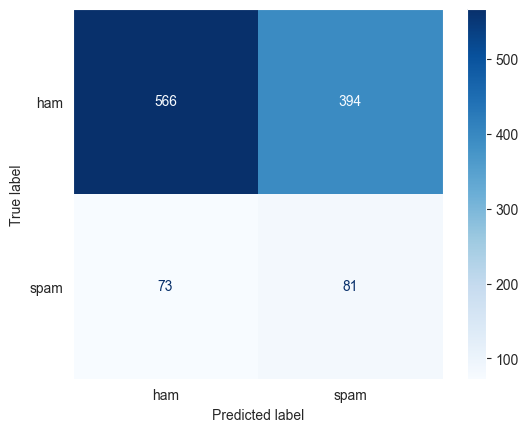

In [201]:
dataset_test = TextDataset('data/test_data.txt', embed_dim=embed_dim, embedding=dataset_train.embedding)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

accuracy_test = 0
loss_test = 0
all_labels = []
all_preds = []
    
for texts_embedded, labels in dataloader_test:
    outputs = model(texts_embedded)
    loss_test += criterion(outputs, labels) 
    
    preds = outputs.argmax(1)
    accuracy_test += torch.sum(preds == labels)
    all_labels.extend(labels.cpu().numpy())
    all_preds.extend(preds.cpu().numpy())
    
    # Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Test loss: {loss_test.item():.4f}, Test accuracy: {accuracy_test / len(all_labels):.4f} "
      f'Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset_test.labels)
disp.plot(cmap="Blues")
plt.grid(False)
plt.show()

## Exercise 5: Training a FastText Model 

We will now use the same dataset we just loaded to train a FastText model to perform classification. Remember, that in FastText, we not only have the option to create models that use word level N-grams, but also character level N-grams. We will try both and compare their performance!

There are a number of parameters that can be passed to the FastText `train_supervised` function, but we will just concern ourselves with a couples of them.

* The `input` parameter requires a text file as an input containing two columns. The first column must be the classification label and the second must be the text.
* The `verbose` parameter just allows us to enable or disable training information. Here we enable it.
* Now try to test the model using the `test` function. (HINT: See https://fasttext.cc/docs/en/supervised-tutorial.html). How good is your performance on the testset?
* What happens when you vary the N-gram size? What is the optimal setting? Why do you think that is the case?
* Look in the FastText documentation to find out how to make a character level model. Can you get better performance this way? Why do you think that is/isn't? 
* Try to tweak some of the parameters and look at what optimal parameter settings are. (HINT: Look at the `maxn` and `minn` parameters. If you find it difficult/annoying doing this manually, consider doing a hyperparameter search grid and find some optimal parameters!).
* Try to preprocess the texts like we did in the previous exercise and see if this helps you!

In [202]:
def test_fasttext_model(test_texts, test_labels, fasttext_model, verbose=False):
    predictions = []
    correct_labels = []
    
    for text, label in zip(test_texts, test_labels):
        prediction = fasttext_model.predict(text)[0][0].replace('__label__', '')
        predictions.append(prediction)
        correct_labels.append(label)
    
    # Calculate confusion matrix
    labels = sorted(set(test_labels))  # Ensure consistent label order
    cm = confusion_matrix(correct_labels, predictions, labels=labels)
    
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.grid(False)
    plt.show()
    
    # Calculate metrics
    TP = np.diag(cm)   # True Positives for each class
    FP = cm.sum(axis=0) - TP  # False Positives
    FN = cm.sum(axis=1) - TP  # False Negatives
    TN = cm.sum() - (FP + FN + TP)  # True Negatives for each class
    
    # Calculate specificity and sensitivity for each class
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    
    # Print metrics
    for i, label in enumerate(labels):
        print(f"Class '{label}':")
        print(f"  Sensitivity (Recall): {sensitivity[i]:.2f}")
        print(f"  Specificity: {specificity[i]:.2f}")
    
    # Calculate overall accuracy
    accuracy = np.sum(TP) / np.sum(cm)
    if verbose:
        print(f'Word model accuracy: {accuracy * 100:.2f} %')
    
    return accuracy, cm, sensitivity, specificity

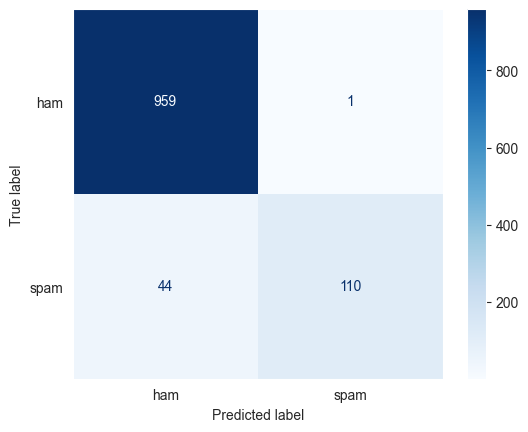

Class 'ham':
  Sensitivity (Recall): 1.00
  Specificity: 0.71
Class 'spam':
  Sensitivity (Recall): 0.71
  Specificity: 1.00
Word model accuracy: 95.96 %


In [203]:
fasttext_word_model = fasttext.train_supervised(input='./data/train_data.txt', verbose=True, wordNgrams=3)
accuracy_word_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_word_model, verbose=True)

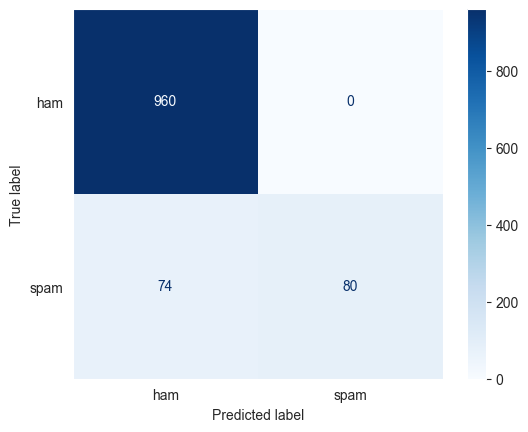

Class 'ham':
  Sensitivity (Recall): 1.00
  Specificity: 0.52
Class 'spam':
  Sensitivity (Recall): 0.52
  Specificity: 1.00
Word model accuracy: 93.36 %


In [204]:
#Create char model here.
char_gram_length_min = 3 # If set to zero, we only train word-grams
char_gram_length_max = 6 # If set to zero, we only train word-grams

fasttext_char_model = fasttext.train_supervised(
    input='./data/train_data.txt',
    verbose=True,
     maxn=char_gram_length_max,
    minn=char_gram_length_min
)
accuracy_char_model = test_fasttext_model(test_texts, test_labels, fasttext_model=fasttext_char_model, verbose=True)